In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from matplotlib import style
from scipy.stats import poisson

style.use('ggplot')

In [2]:
def partial_dataset(my_dataset): #前後五筆資料
    return pd.concat([my_dataset.head(), my_dataset.tail()], axis=0)


<h3>日期範圍</h3>

In [3]:
start_date = dt.datetime(2021, 1, 1)
end_date = dt.datetime(2021, 12, 31)
start_date,end_date

(datetime.datetime(2021, 1, 1, 0, 0), datetime.datetime(2021, 12, 31, 0, 0))

<h3>載入HPE股價</h3>

In [4]:
hpe_prices = web.DataReader('HPE', 'yahoo', start_date, end_date)
hpe_prices.columns = [ 'High', 'Low', 'Open', 'Close', 'Volume', 'AdjClose' ]

In [5]:
partial_dataset(hpe_prices)

,High,Low,Open,Close,Volume,AdjClose
Date,,,,,,
2020-12-31,11.880000,11.640,11.67,11.85,5700700.0,11.395525
2021-01-04,12.000000,11.530,11.90,11.57,8007200.0,11.126262
2021-01-05,11.870000,11.570,11.57,11.78,10969100.0,11.328207
2021-01-06,12.250000,11.920,11.96,12.04,9752200.0,11.578237
2021-01-07,12.240000,11.945,12.16,11.97,10019700.0,11.510921
2021-12-27,15.970000,15.700,15.75,15.92,4456300.0,15.803299
2021-12-28,16.045000,15.850,15.90,15.97,6010800.0,15.852933
2021-12-29,16.215000,15.940,15.97,16.07,5867300.0,15.952199
2021-12-30,16.180000,15.860,16.02,15.89,6608100.0,15.773520


<h3>衍生欄位</h3>

In [6]:
hpe_prices['Volume'] = hpe_prices['Volume'] / 1000.0
hpe_prices['Scale'] = hpe_prices['Close'] - hpe_prices['Open']
hpe_prices['Net'] = hpe_prices['High'] - hpe_prices['Low']

In [7]:
partial_dataset(hpe_prices)

,High,Low,Open,Close,Volume,AdjClose,Scale,Net
Date,,,,,,,,
2020-12-31,11.880000,11.640,11.67,11.85,5700.7,11.395525,0.180000,0.240000
2021-01-04,12.000000,11.530,11.90,11.57,8007.2,11.126262,-0.330000,0.470000
2021-01-05,11.870000,11.570,11.57,11.78,10969.1,11.328207,0.210000,0.300000
2021-01-06,12.250000,11.920,11.96,12.04,9752.2,11.578237,0.080000,0.330000
2021-01-07,12.240000,11.945,12.16,11.97,10019.7,11.510921,-0.190000,0.295000
2021-12-27,15.970000,15.700,15.75,15.92,4456.3,15.803299,0.170000,0.270000
2021-12-28,16.045000,15.850,15.90,15.97,6010.8,15.852933,0.070001,0.195000
2021-12-29,16.215000,15.940,15.97,16.07,5867.3,15.952199,0.099999,0.275001
2021-12-30,16.180000,15.860,16.02,15.89,6608.1,15.773520,-0.130000,0.320001


In [8]:
hpe_diffs = hpe_prices.diff()[1:] #diff與前一期的差,[1:]過濾第一筆
hpe_diffs.columns = [ 'D_%s' % e for e in hpe_diffs.columns.tolist() ] #tolist轉成python陣列
hpe_returns = hpe_prices.pct_change()[1:]
hpe_returns.columns = [ 'P_%s' % e for e in hpe_returns.columns.tolist() ]
hpe_diffs_returns = pd.concat([hpe_diffs, hpe_returns], axis=1) #index一樣,aixs=1表示欄位的合併,0表示資料筆數合併
hpe_prices_diffs_returns = pd.concat([hpe_prices, hpe_diffs_returns], axis=1)

hpe_prices_diffs_returns['Week'] = [ e.isocalendar()[1] for e in hpe_prices_diffs_returns.index ]
#isocalendar() 年-月-日,[1]得到週數
for i in range(8, 25): #D_High ~ Week
    hpe_prices_diffs_returns.iat[0, i] = 0 #把NaN轉成0
hpe_prices_diffs_returns.head(5) 

,High,Low,Open,Close,Volume,AdjClose,Scale,Net,D_High,D_Low,...,D_Net,P_High,P_Low,P_Open,P_Close,P_Volume,P_AdjClose,P_Scale,P_Net,Week
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-31,11.88,11.640,11.67,11.85,5700.7,11.395525,0.18,0.240,0.00,0.000000,...,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2021-01-04,12.00,11.530,11.90,11.57,8007.2,11.126262,-0.33,0.470,0.12,-0.110001,...,0.230,0.010101,-0.009450,0.019709,-0.023629,0.404599,-0.023629,-2.833330,0.958336,1
2021-01-05,11.87,11.570,11.57,11.78,10969.1,11.328207,0.21,0.300,-0.13,0.040000,...,-0.170,-0.010833,0.003469,-0.027731,0.018150,0.369905,0.018150,-1.636364,-0.361702,1
2021-01-06,12.25,11.920,11.96,12.04,9752.2,11.578237,0.08,0.330,0.38,0.350000,...,0.030,0.032013,0.030251,0.033708,0.022071,-0.110939,0.022071,-0.619048,0.099999,1
2021-01-07,12.24,11.945,12.16,11.97,10019.7,11.510921,-0.19,0.295,-0.01,0.025000,...,-0.035,-0.000816,0.002097,0.016722,-0.005814,0.027430,-0.005814,-3.374997,-0.106060,1


In [9]:
hpe_prices2 = None
_hpe_prices = hpe_prices_diffs_returns[1:].copy() #過濾掉第一筆

for column_name in _hpe_prices.columns.tolist():
    #print(column_name)
    if column_name == 'Week':
        continue #跳過Week這行
        
    _dataset = _hpe_prices[['Week', column_name]].copy() #一行一行拿出來做計算
    hpe_week = _dataset.groupby(by=['Week']).agg(['mean', 'std'])
    hpe_week.columns = ['A_%s' % column_name, 'S_%s' % column_name]
    
    if hpe_prices2 is None:
        hpe_prices2 = hpe_week
    else:
        hpe_prices2 = pd.concat([hpe_prices2, hpe_week], axis=1)
hpe_prices2.head(5) 

,A_High,S_High,A_Low,S_Low,A_Open,S_Open,A_Close,S_Close,A_Volume,S_Volume,...,A_P_Close,S_P_Close,A_P_Volume,S_P_Volume,A_P_AdjClose,S_P_AdjClose,A_P_Scale,S_P_Scale,A_P_Net,S_P_Net
Week,,,,,,,,,,,,,,,,,,,,,
1,12.07800,0.163921,11.74600,0.192269,11.914,0.215360,11.8480,0.183494,9779.86,1090.037005,...,0.000652,0.019125,0.140822,0.231629,0.000652,0.019125,-1.787485,1.296933,0.097775,0.508190
2,12.39900,0.320671,12.03200,0.255871,12.158,0.343686,12.2600,0.241557,9388.06,2245.838470,...,0.010906,0.009253,0.072247,0.251055,0.010906,0.009253,3.262290,11.099373,0.222291,0.470744
3,12.39625,0.204506,12.12125,0.220393,12.330,0.205102,12.2625,0.088081,7792.90,2369.501014,...,-0.008044,0.008590,0.034651,0.484520,-0.008044,0.008590,-1.055600,1.904209,0.055217,0.621976
4,12.73200,0.394233,12.13200,0.267736,12.426,0.418246,12.4980,0.343686,11665.26,5478.640013,...,0.003939,0.041250,0.323184,1.220970,0.003939,0.041250,-1.793115,4.295198,0.292591,0.942686
5,12.82100,0.286801,12.45700,0.322017,12.592,0.273989,12.7100,0.348568,7010.78,546.429988,...,0.012707,0.012802,-0.055670,0.225581,0.012707,0.012802,-0.660056,2.066874,-0.033230,0.535874


In [10]:
hpe_prices_diffs_returns_week = hpe_prices_diffs_returns.join(hpe_prices2, on='Week')
hpe_prices_diffs_returns_week.dropna(inplace=True)

hpe_prices_diffs_returns_week.to_hdf('HPE.h5', 'HPE')
hpe_prices_diffs_returns_week.head(5) 

,High,Low,Open,Close,Volume,AdjClose,Scale,Net,D_High,D_Low,...,A_P_Close,S_P_Close,A_P_Volume,S_P_Volume,A_P_AdjClose,S_P_AdjClose,A_P_Scale,S_P_Scale,A_P_Net,S_P_Net
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,12.00,11.530,11.90,11.57,8007.2,11.126262,-0.330000,0.470000,0.12,-0.110001,...,0.000652,0.019125,0.140822,0.231629,0.000652,0.019125,-1.787485,1.296933,0.097775,0.50819
2021-01-05,11.87,11.570,11.57,11.78,10969.1,11.328207,0.210000,0.300000,-0.13,0.040000,...,0.000652,0.019125,0.140822,0.231629,0.000652,0.019125,-1.787485,1.296933,0.097775,0.50819
2021-01-06,12.25,11.920,11.96,12.04,9752.2,11.578237,0.080000,0.330000,0.38,0.350000,...,0.000652,0.019125,0.140822,0.231629,0.000652,0.019125,-1.787485,1.296933,0.097775,0.50819
2021-01-07,12.24,11.945,12.16,11.97,10019.7,11.510921,-0.190000,0.295000,-0.01,0.025000,...,0.000652,0.019125,0.140822,0.231629,0.000652,0.019125,-1.787485,1.296933,0.097775,0.50819
2021-01-08,12.03,11.765,11.98,11.88,10151.1,11.424374,-0.099999,0.264999,-0.21,-0.179999,...,0.000652,0.019125,0.140822,0.231629,0.000652,0.019125,-1.787485,1.296933,0.097775,0.50819


In [11]:
hpe_prices_diffs_returns_week = pd.read_hdf('HPE.h5')

#日期範圍
start_date = hpe_prices_diffs_returns_week.index[0]
end_date = hpe_prices_diffs_returns_week.index[-1]
hpe_prices_diffs_returns_week.head(5) 

,High,Low,Open,Close,Volume,AdjClose,Scale,Net,D_High,D_Low,...,A_P_Close,S_P_Close,A_P_Volume,S_P_Volume,A_P_AdjClose,S_P_AdjClose,A_P_Scale,S_P_Scale,A_P_Net,S_P_Net
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,12.00,11.530,11.90,11.57,8007.2,11.126262,-0.330000,0.470000,0.12,-0.110001,...,0.000652,0.019125,0.140822,0.231629,0.000652,0.019125,-1.787485,1.296933,0.097775,0.50819
2021-01-05,11.87,11.570,11.57,11.78,10969.1,11.328207,0.210000,0.300000,-0.13,0.040000,...,0.000652,0.019125,0.140822,0.231629,0.000652,0.019125,-1.787485,1.296933,0.097775,0.50819
2021-01-06,12.25,11.920,11.96,12.04,9752.2,11.578237,0.080000,0.330000,0.38,0.350000,...,0.000652,0.019125,0.140822,0.231629,0.000652,0.019125,-1.787485,1.296933,0.097775,0.50819
2021-01-07,12.24,11.945,12.16,11.97,10019.7,11.510921,-0.190000,0.295000,-0.01,0.025000,...,0.000652,0.019125,0.140822,0.231629,0.000652,0.019125,-1.787485,1.296933,0.097775,0.50819
2021-01-08,12.03,11.765,11.98,11.88,10151.1,11.424374,-0.099999,0.264999,-0.21,-0.179999,...,0.000652,0.019125,0.140822,0.231629,0.000652,0.019125,-1.787485,1.296933,0.097775,0.50819


In [13]:
my_stock=hpe_prices_diffs_returns_week[['Volume','P_Volume','D_Volume','A_Volume','S_Volume']]

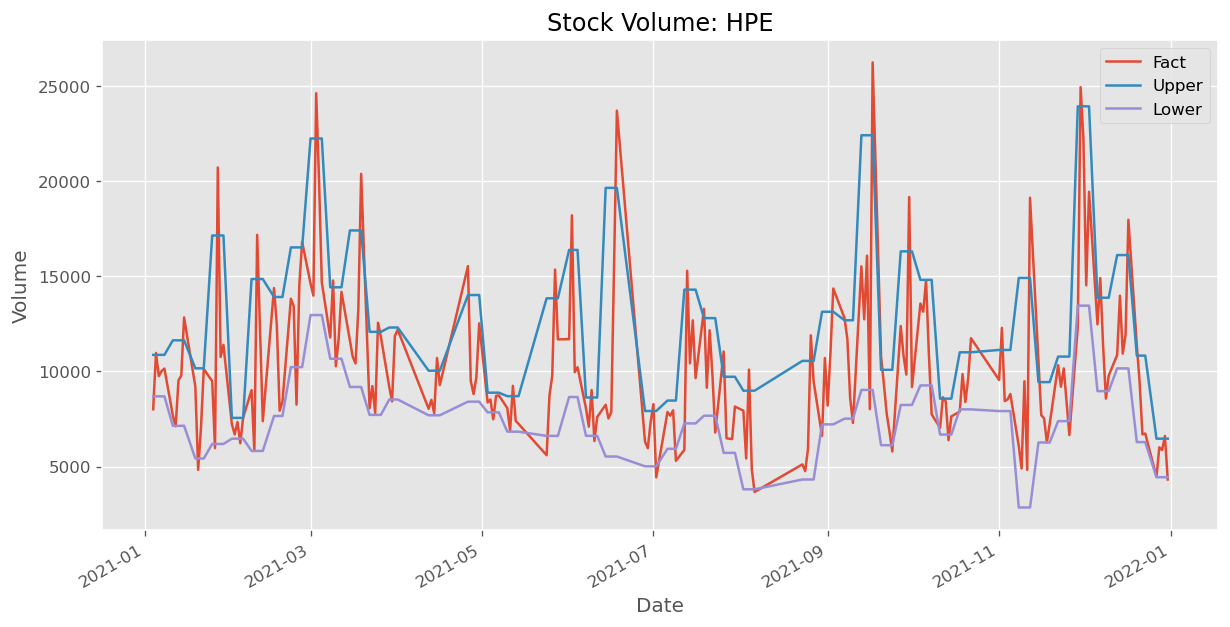

In [14]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=120)

my_stock['Volume'].plot(label='Fact')

upper = my_stock['A_Volume'] + my_stock['S_Volume']
lower = my_stock['A_Volume'] - my_stock['S_Volume']

upper.plot(label='Upper')
lower.plot(label='Lower')

ax.set_title('Stock Volume: HPE')

plt.xlabel('Date')
plt.ylabel('Volume')

plt.legend(loc='best')

plt.show()

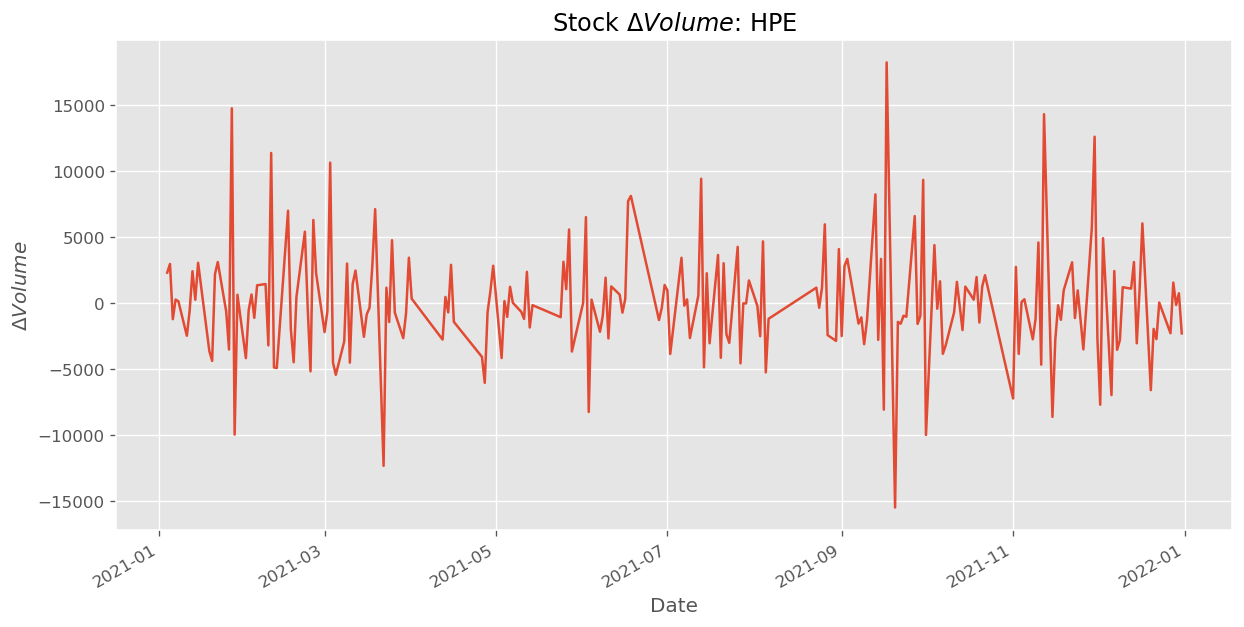

In [15]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=120)

my_stock['D_Volume'].plot() #兩天之間的變化量

ax.set_title('Stock $\Delta {Volume} $: HPE')

plt.xlabel('Date')
plt.ylabel('$\Delta {Volume} $')

plt.show()

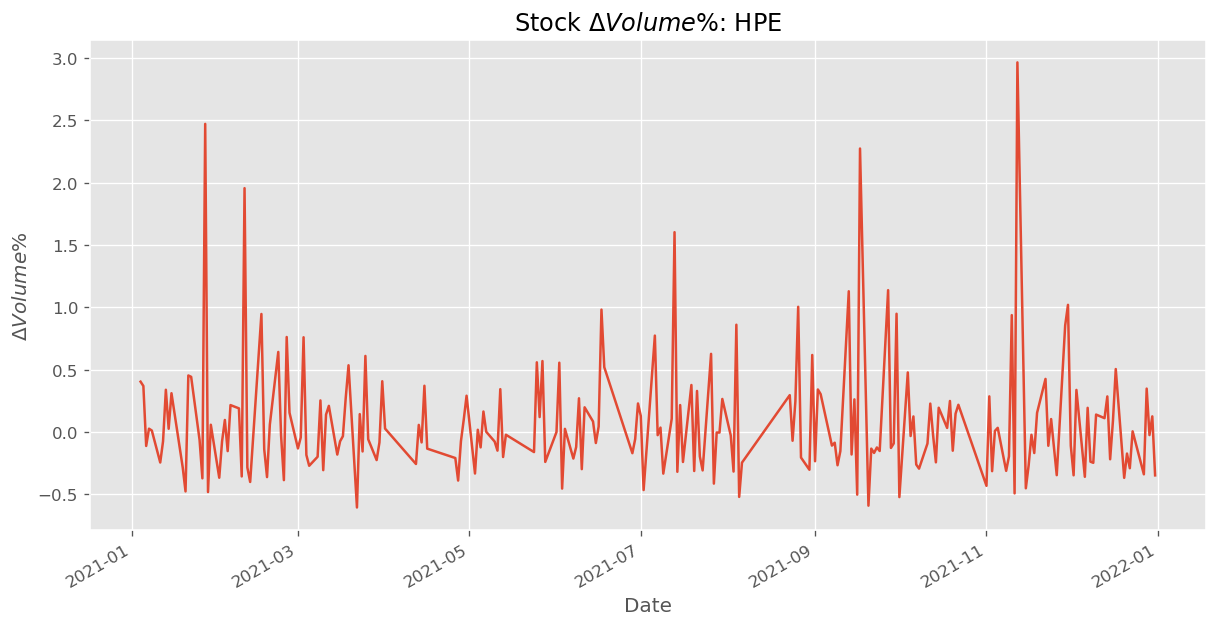

In [16]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=120)

my_stock['P_Volume'].plot()

ax.set_title('Stock $\Delta {Volume} \% $: HPE')

plt.xlabel('Date')
plt.ylabel('$\Delta {Volume} \% $')

plt.show()

<h3>Monte Carlo 模擬</h3>

In [17]:
num_simulations = 10
num_days = my_stock.shape[0] #資料筆數=幾天

simulation_df = None

for i in range(num_simulations):
    _my_stock = []
    
    for day in range(num_days): #一天一天看
        row = my_stock.iloc[day]
        
        #daily_vol_upper = row['A_Volume'] + row['S_Volume']
        #daily_vol_lower = row['A_Volume'] - row['S_Volume']
        daily_vol_mean = row['A_Volume'] 
        
        #在lower和upper之間震盪
        #_ibm_volume = np.random.uniform(low=daily_vol_lower, high=daily_vol_upper)
        _hpe_volume = np.random.poisson(lam= daily_vol_mean , size=None)
        if _hpe_volume <= 0:#若有奇異值
            _hpe_volume = row['Volume']
            
        _my_stock.append(_hpe_volume)
    
    subset = pd.DataFrame(data={'%d' % i: _my_stock.copy() })
    
    if simulation_df is None:
        simulation_df = subset
    else:
        simulation_df = pd.concat([simulation_df, subset], axis=1)
simulation_df

,0,1,2,3,4,5,6,7,8,9
0,9845,9783,9956,9925,9828,9609,9622,9724,9740,9698
1,9881,9818,9646,9768,9909,9840,9700,9909,9904,9779
2,9569,9605,9697,9868,9701,9602,9846,9788,9643,9566
3,9893,9694,9839,9638,9887,9937,9837,9843,9743,9912
4,9615,9707,9786,9696,9850,9800,9755,9769,9767,9861
...,...,...,...,...,...,...,...,...,...,...
212,5430,5420,5567,5568,5552,5338,5550,5552,5410,5341
213,5499,5332,5367,5426,5317,5504,5450,5396,5429,5401
214,5494,5439,5397,5468,5400,5406,5518,5463,5426,5428
215,5461,5465,5551,5354,5386,5485,5346,5357,5433,5565


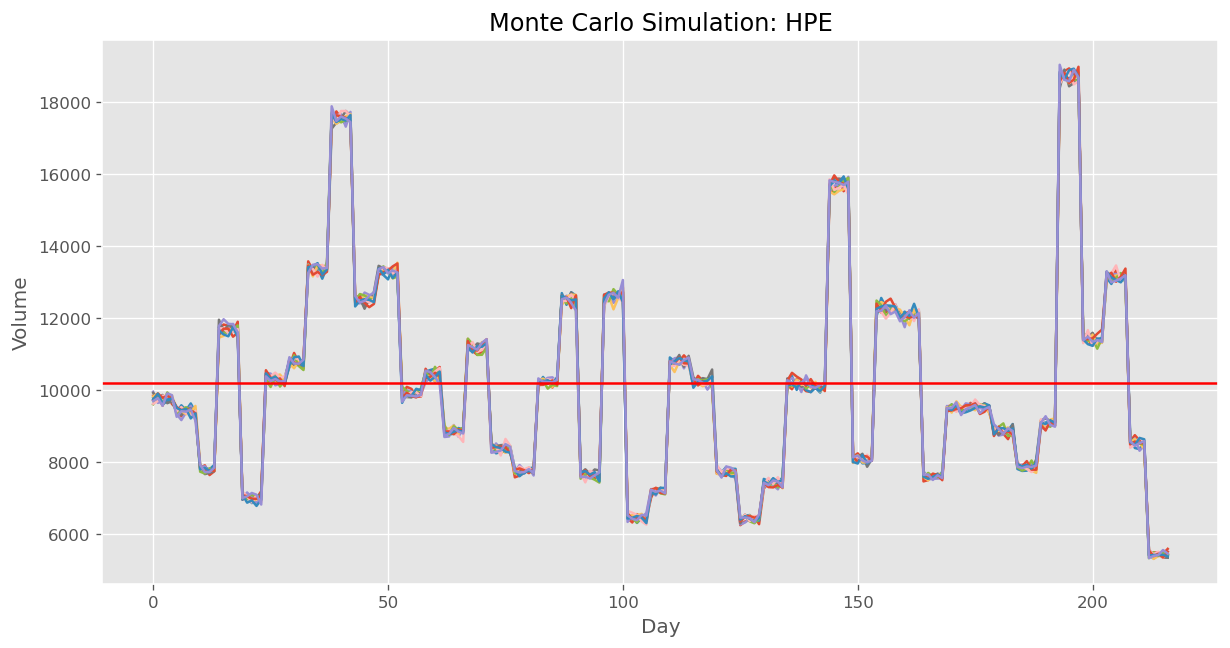

In [18]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=120)

ax.plot(simulation_df)
ax.axhline(y=my_stock['A_Volume'].mean(), color = 'r', linestyle = '-')

ax.set_title('Monte Carlo Simulation: HPE')

plt.xlabel('Day')
plt.ylabel('Volume')

plt.show()